In [19]:
import os, sys
from matplotlib import pyplot as plt
import numpy as np
import rasterio as rio
from shapely.geometry import Polygon
from scipy.misc import bytescale
from rasterio.mask import mask
from glob import glob

# add the unet helpers
sys.path.append('../../')
from test_unet_helpers import *
from unet_models import unet11_MS
from utils import variable

import matplotlib
%matplotlib inline
from pylab import *
rcParams['figure.figsize'] = 10, 10

font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 14}

matplotlib.rc('font', **font)

In [2]:
# lulc_files = sorted(glob('../../RD/debug_IS_segmentation/kmeans3_split/dg_products/tiles_d10000_256x256/val/lulc*.tif'))
# bue_files = sorted(glob('../../RD/debug_IS_segmentation/kmeans3_split/dg_products/tiles_d10000_256x256/val/bue*.tif'))
# unet_files = sorted(glob('../../RD/debug_IS_segmentation/kmeans3_split/dg_products/tiles_d10000_256x256/val/unet*.tif'))
# dg_files = sorted(glob('../../RD/debug_IS_segmentation/kmeans3_split/tiles_d10000_256x256/val/dg*.tif'))
# gt_files = sorted(glob('../../RD/debug_IS_segmentation/kmeans3_split/tiles_d10000_256x256/val/gt*.tif'))

lulc_files = sorted(glob.glob('../../../tiles/dg_products/tiles_d10000_256x256/val/lulc*.tif'))
bue_files = sorted(glob.glob('../../../tiles/dg_products/tiles_d10000_256x256/val/bue*.tif'))
unet_files = sorted(glob.glob('../../../tiles/dg_products/tiles_d10000_256x256/val/unet*.tif'))
dg_files = sorted(glob.glob('../../../tiles/kmeans3_split/tiles_d10000_256x256/val/dg*.tif'))
gt_files = sorted(glob.glob('../../../tiles/kmeans3_split/tiles_d10000_256x256/val/gt*.tif'))

In [3]:
lulc_files[:5], bue_files[:5]

(['../../../tiles/dg_products/tiles_d10000_256x256/val/lulc_is_00500.tif',
  '../../../tiles/dg_products/tiles_d10000_256x256/val/lulc_is_00501.tif',
  '../../../tiles/dg_products/tiles_d10000_256x256/val/lulc_is_00502.tif',
  '../../../tiles/dg_products/tiles_d10000_256x256/val/lulc_is_00503.tif',
  '../../../tiles/dg_products/tiles_d10000_256x256/val/lulc_is_00504.tif'],
 ['../../../tiles/dg_products/tiles_d10000_256x256/val/bue_is_00500.tif',
  '../../../tiles/dg_products/tiles_d10000_256x256/val/bue_is_00501.tif',
  '../../../tiles/dg_products/tiles_d10000_256x256/val/bue_is_00502.tif',
  '../../../tiles/dg_products/tiles_d10000_256x256/val/bue_is_00503.tif',
  '../../../tiles/dg_products/tiles_d10000_256x256/val/bue_is_00504.tif'])

## iterate through the ground truth raster and process a window which has more than 80% impervious cover

## iterate over the UNet results

In [4]:
# RGB-NIR
model_path = './files_MS_aug_bgrn1/bgrn1_ms_aug_ep500_step16000_b32.pt' #auc range of 0.66 to 0.93, mean of 0.79
# model_path = './files_MS_aug_bgrn1/bgrn1_ms_aug_ep400_step12800_b32.pt' #auc range of 0.64 to 0.94, mean of 0.73

torch.cuda.empty_cache()

#model = unet11(pretrained=False) # B-G-R
model = unet11_MS(num_bands=4, pretrained=False) 
model.eval()

# load on CPU
if os.path.exists(model_path):
    state_dict = torch.load(str(model_path), map_location='cpu')
    epoch = state_dict['epoch']
    step = state_dict['step']
    new_state_dict = OrderedDict()
    for k, v in state_dict['model'].items():
        name = k[7:] # remove 'module.' of dataparallel
        new_state_dict[name]=v

    model.load_state_dict(new_state_dict)
    #print('Restored model, epoch {}, step {:,}'.format(epoch, step))

# define a function to load and run model
def run_model(chip, mod):   
    

    img_arr = chip[[1,2,4,6], :, :] #B-G-R-N1
    img_arr = torch.from_numpy(img_arr)

    input_img = torch.unsqueeze(variable(img_arr, volatile=True), dim=0).cpu()
    del img_arr

    # model inference
    big_mask = model(input_img)

    return big_mask.cpu().detach().numpy().squeeze()

num_bands is  4


In [5]:
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc

## iterate over the UNET rasters
labels=('UNet 4 band')
unet_label = labels
winsize=100


dg_lulc_auc = []
dg_lulc_fpr = []
dg_lulc_tpr = []

dg_bue_auc = []
dg_bue_fpr = []
dg_bue_tpr = []

unet_auc = []
unet_fpr = []
unet_tpr = []

r = []
c = []
for i in range(len(unet_files)):

    # get the gt window
    with rio.open(gt_files[i]) as src:
        target = src.read()
        
    area_thresh = target[target>0].size / target.size

    # check the 80%
    

    try:

        # for LULC
        with rio.open(lulc_files[i]) as src:
            lulc = src.read()
            lulc = np.sum(lulc, axis=0)
            pred = np.zeros(lulc.shape)
            pred[lulc == 384] = 1

        roc_score = roc_auc_score(target.flatten(), pred.flatten())
        false_positive_rate, true_positive_rate, thresholds = roc_curve(target.flatten(), pred.flatten())
        roc_auc = auc(false_positive_rate, true_positive_rate)
        dg_lulc_auc.append(roc_auc)
        dg_lulc_fpr.append(false_positive_rate)
        dg_lulc_tpr.append(true_positive_rate)

        # for BUE
        with rio.open(bue_files[i]) as src:
            pred = src.read()

        roc_score = roc_auc_score(target.flatten(), pred.flatten())
        false_positive_rate, true_positive_rate, thresholds = roc_curve(target.flatten(), pred.flatten())
        roc_auc = auc(false_positive_rate, true_positive_rate)
        dg_bue_auc.append(roc_auc)
        dg_bue_fpr.append(false_positive_rate)
        dg_bue_tpr.append(true_positive_rate)

        # for UNet... need to pass to the model and get the output
        #with rio.open(unet_files[i]) as src:
        #    pred = src.read()
        with rio.open(dg_files[i]) as src:
            dg_arr = src.read()

        pred = run_model(dg_arr, model)
        roc_score = roc_auc_score(target.flatten(), pred.flatten())
        false_positive_rate, true_positive_rate, thresholds = roc_curve(target.flatten(), pred.flatten())
        roc_auc = auc(false_positive_rate, true_positive_rate)
        unet_auc.append(roc_auc)
        unet_fpr.append(false_positive_rate)
        unet_tpr.append(true_positive_rate)


    except Exception as e:
        # we likely have a dimension mismatch
        print(e)
        continue

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
../../utils.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return cuda(Variable(x, volatile=volatile))


/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


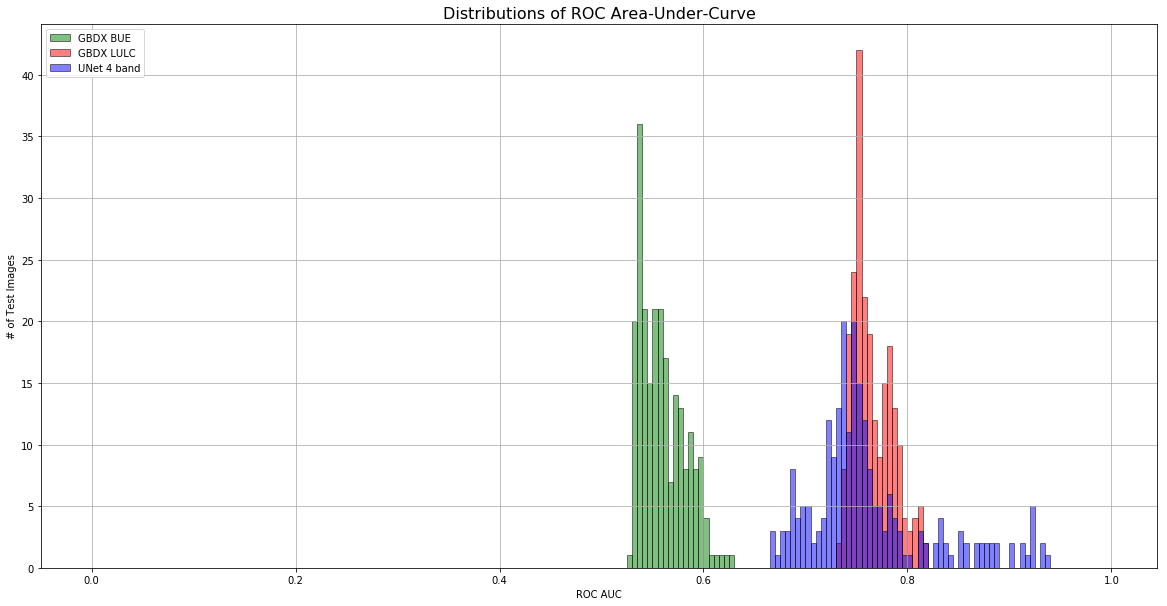

In [6]:
# show the distribution of ROC AUC (area under curve)
plt.figure(figsize=(20,10))
res = 0.005
plt.hist(dg_bue_auc, bins=np.arange(0., 1., res), color='g', alpha=0.5, edgecolor='k', label='GBDX BUE');
plt.hist(dg_lulc_auc, bins=np.arange(0., 1., res), color='r', alpha=0.5, edgecolor='k', label='GBDX LULC');
plt.hist(unet_auc, bins=np.arange(0., 1., res), color='b', alpha=0.5, edgecolor='k', label=unet_label)
plt.legend(loc='upper left')
plt.title('Distributions of ROC Area-Under-Curve', fontsize=16)
plt.ylabel('# of Test Images',)
plt.xlabel('ROC AUC')
plt.grid(True)
plt.show()

# pick a random sample for TPR vs FPR
#     plt.figure(figsize=(10,5))
#     plt.plot(dg_bue_fpr[10], dg_bue_tpr[10], c='g')
#     plt.plot(dg_lulc_fpr[10], dg_lulc_tpr[10], c='r')
#     plt.plot(unet_fpr[10], unet_tpr[10], c='b')
#     plt.show()

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


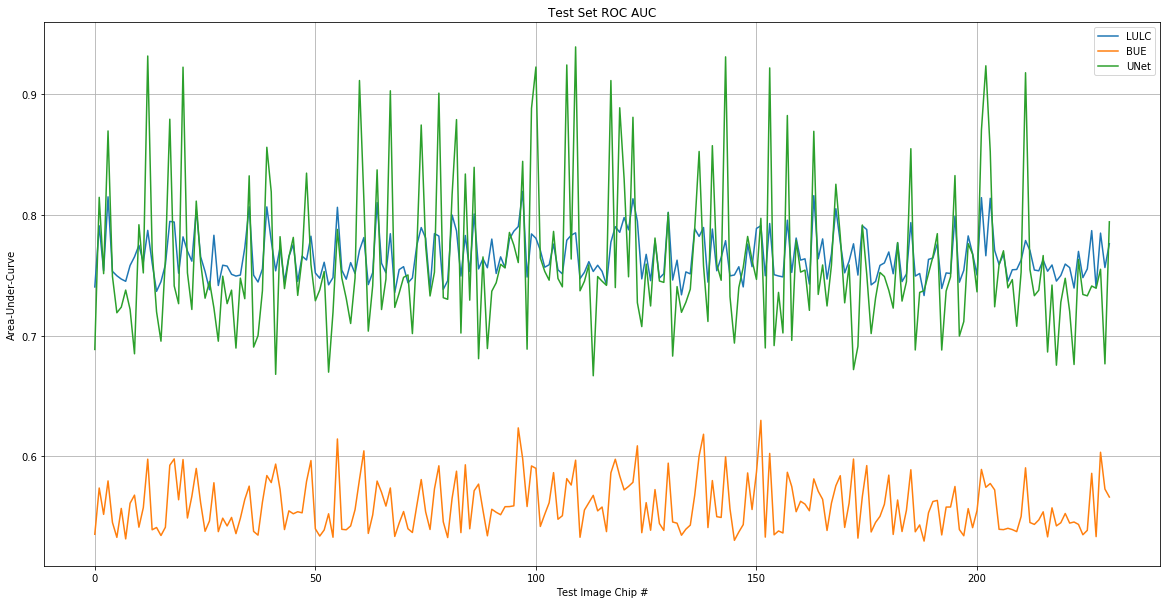

231

In [7]:
plt.figure(figsize=(20,10))
plt.plot(dg_lulc_auc, label='LULC')
plt.plot(dg_bue_auc, label='BUE')
plt.plot(unet_auc, label='UNet')
plt.xlabel('Test Image Chip #')
plt.ylabel('Area-Under-Curve')
plt.title('Test Set ROC AUC')
plt.legend()
plt.grid(True)
plt.show()

len(unet_auc)

../../utils.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return cuda(Variable(x, volatile=volatile))
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


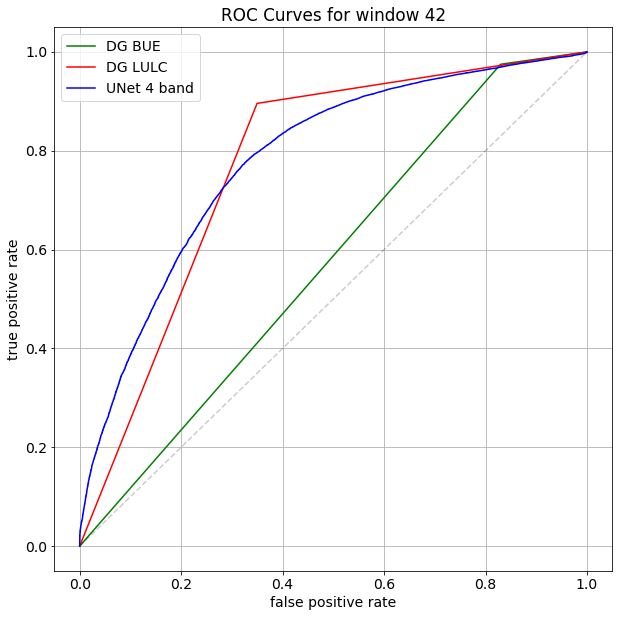

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/ipykernel/__main__.py:58: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


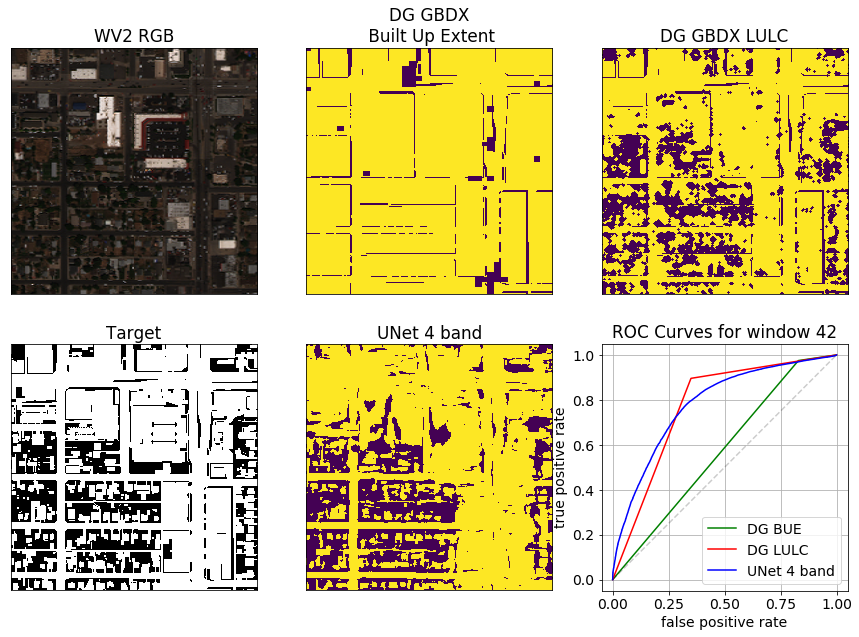

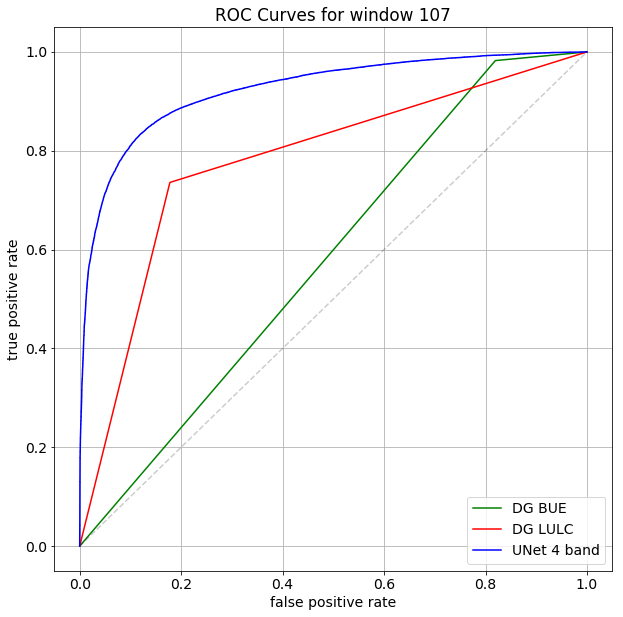

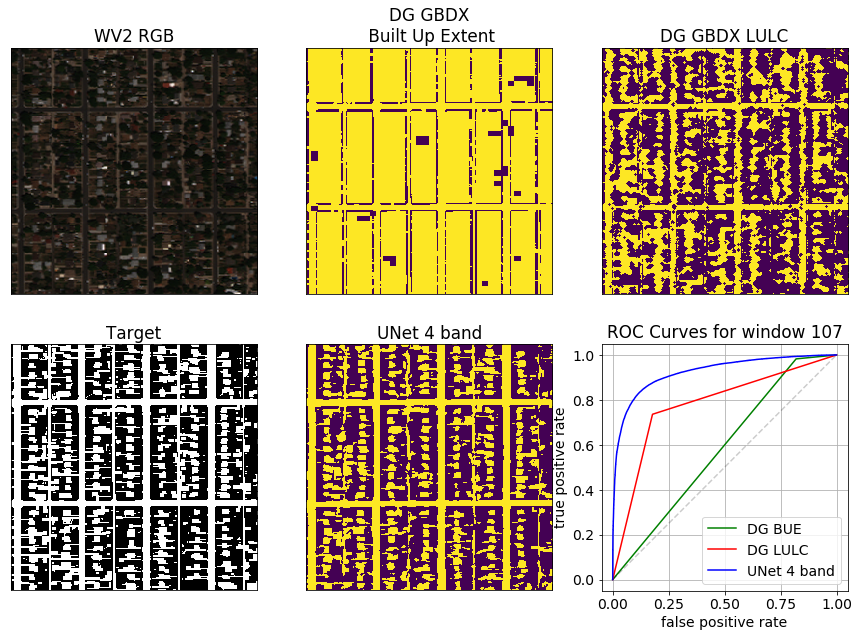

In [20]:
from scipy.misc import bytescale


# pick a random sample for TPR vs FPR
np.random.seed(22)
#for randind in np.random.choice(len(dg_bue_fpr), 42, replace=False):
#for randind in range(len(unet_files)):
for randind in [42, 107]:
    
    # read data
    #lulc
    with rio.open(lulc_files[randind]) as src:
        lulc = src.read()
        lulc = np.sum(lulc, axis=0)
        manmade = np.zeros(lulc.shape)
        manmade[lulc == 384] = 1
    
    #unet
    #with rio.open(unet_files[i]) as src:
    #    arr = src.read(1)
    
    with rio.open(dg_files[randind]) as src:
        dg_arr = src.read()

    arr = run_model(dg_arr, model)
        
    #bue
    with rio.open(bue_files[randind]) as src:
        dg_bue_arr = src.read(1)
    
    #gt
    with rio.open(gt_files[randind]) as src:
        gt_arr = src.read(1)
        
    #dg
    with rio.open(dg_files[randind]) as src:
        src_arr = src.read()
        src_arr = np.rollaxis(src_arr, 0,3)
    
    plt.figure(figsize=(10,10))
    plt.plot(dg_bue_fpr[randind], dg_bue_tpr[randind], 'g', label='DG BUE')
    plt.plot(dg_lulc_fpr[randind], dg_lulc_tpr[randind],'r', label='DG LULC')
    plt.plot(unet_fpr[randind], unet_tpr[randind], 'b', label='UNet 4 band')
    plt.plot([0,1], '--k', alpha=0.2)
    plt.legend()
    plt.grid()
    plt.title('ROC Curves for window {}'.format(randind))
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.show()
    
        
    # make a plot for the image arrays
    #fig, ax = plt.subplots(2, 3, figsize=(15,10), sharex='col', sharey='row')
    fig, ax = plt.subplots(2, 3, figsize=(15,10))
    
    # plot the RGB image (top left)
    ax[0,0].imshow(bytescale(src_arr[:,:, [4,2,1]]))
    ax[0,0].set_title('WV2 RGB')
    ax[0,0].set_xticks([])
    ax[0,0].set_yticks([])
    
#     cur_axes = fig.gca()
#     cur_axes.axes.get_xaxis().set_ticklabels([])
#     cur_axes.axes.get_yaxis().set_ticklabels([])
    
    # plot the ground truth image (bottom left)
    ax[1,0].imshow(gt_arr, cmap='gray')
    ax[1,0].set_title('Target')
    ax[1,0].set_xticks([])
    ax[1,0].set_yticks([])
    

    # plot the DG images
    ax[0,1].imshow(dg_bue_arr)
    ax[0,1].set_title('DG GBDX\n Built Up Extent')
    ax[0,1].set_xticks([])
    ax[0,1].set_yticks([])
    
    ax[0,2].imshow(manmade)
    ax[0,2].set_title('DG GBDX LULC')
    ax[0,2].set_xticks([])
    ax[0,2].set_yticks([])
    

    ax[1,1].imshow(arr > 0)
    ax[1,1].set_title('UNet 4 band')
    ax[1,1].set_xticks([])
    ax[1,1].set_yticks([])
    
    
    ax[1,2].plot(dg_bue_fpr[randind], dg_bue_tpr[randind], 'g', label='DG BUE')
    ax[1,2].plot(dg_lulc_fpr[randind], dg_lulc_tpr[randind], 'r', label='DG LULC')
    ax[1,2].plot(unet_fpr[randind], unet_tpr[randind], 'b', label='UNet 4 band')
    ax[1,2].plot([0,1], '--k', alpha=0.2)
    ax[1,2].legend()
    ax[1,2].grid()
    ax[1,2].set_title('ROC Curves for window {}'.format(randind))
    ax[1,2].set_xlabel('false positive rate')
    ax[1,2].set_ylabel('true positive rate')
    
    
    
    plt.show()

    

In [ ]:
min(unet_auc), np.mean(unet_auc), max(unet_auc)

In [ ]:
plt.figure(figsize=(10,10))
for i in range(len(unet_fpr)):
    plt.plot(unet_fpr[i], unet_tpr[i])
    

plt.plot([0,1], [0,1], '--r')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves for Test Set: Blue-Green-Red-NIR1 Bands', fontsize=16)
plt.show()